Meeting notes:
Story: how does community info encoded, when does it matter?

Do norms capture degree? or maybe if they're adding some centrality measure but is that reducing the performance? Where does the centrality info used in the random walks go? in the angles? LFR doesn't have correlation (no traiangles) Does norm capture degree? and angular info captures community? In correlated networks does it help to separate or combine both pieces of info?

Use core periphery structure networks an extreme example to test it out.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:13<00:00, 107.57it/s, loss=1.38]
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_a

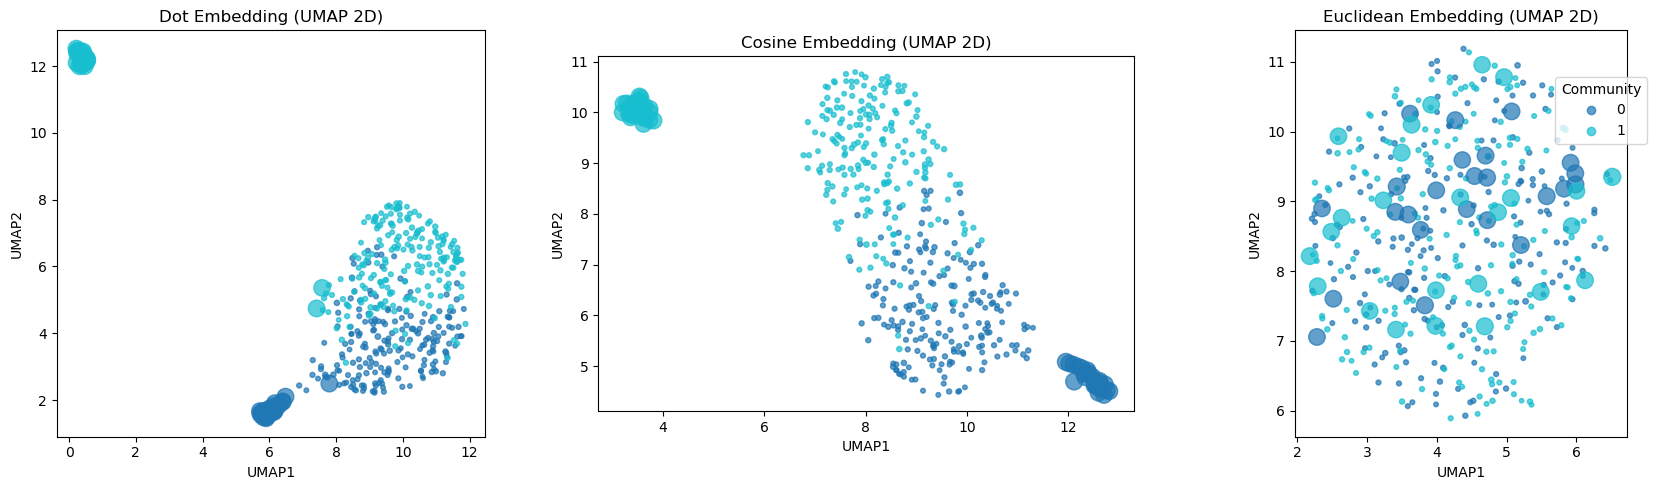

ROC-AUC on periphery communities (0 vs 1):
                dot    cosine  norm_diff  euc_on_norm
dot        0.521512  0.695213   0.495441     0.695212
cosine     0.564303  0.752868   0.497627     0.752868
euclidean  0.507995  0.497842   0.503240     0.497842


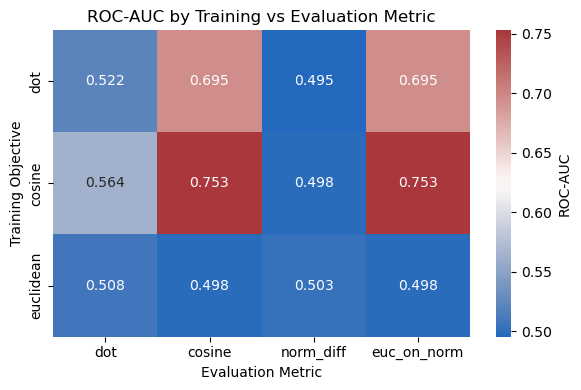

K-Means performance (ARI & Element-Centric):
           ARI_periphery  ECS_periphery  ARI_all_nodes  ECS_all_nodes
dot             0.584194       0.532404      -0.000893       0.000057
cosine          0.756294       0.697105       0.773900       0.716550
euclidean       0.003940       0.005753      -0.000250       0.001917


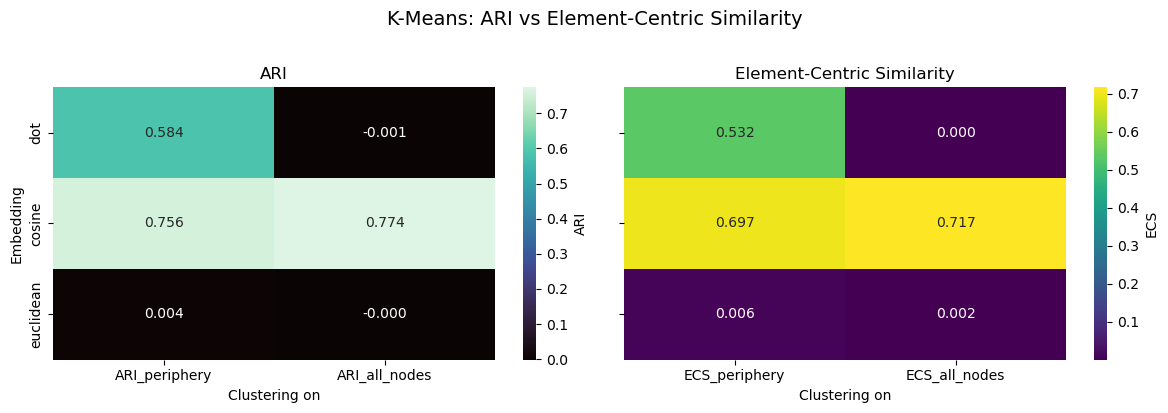

In [8]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score, normalized_mutual_info_score
from node2vecs import TorchNode2Vec

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.sparse as sp
import pandas as pd
import umap

import os
import random
import torch

# assuming calc_esim is already defined, and:
# embeddings: dict of name→(N×d) arrays,
# labels: length-N array in {0,1} for periphery and hubs assigned 0/1,
# n, H defined as before
def calc_esim(y, ypred):

    ylab, y = np.unique(y, return_inverse=True)
    ypredlab, ypred = np.unique(ypred, return_inverse=True)
    
    Ka, Kb = len(ylab), len(ypredlab)
    K = np.maximum(Ka, Kb)
    N = len(y)
    
    UA = sp.csr_matrix((np.ones_like(y), (np.arange(y.size), y)), shape=(N,K))
    UB = sp.csr_matrix((np.ones_like(ypred), (np.arange(ypred.size), ypred)), shape=(N, K))    
    
    nA = np.array(UA.sum(axis=0)).reshape(-1)
    nB = np.array(UB.sum(axis=0)).reshape(-1)

# nAB[i][j] is read as the number of elements that belong to ith ground truth label and jth predicrted label.
# nAB[1][0] = 1 For ground truth label with index 1 and predicted label 0 we have 1 element. i.e. 0000|1| vs 1110|0|

    nAB = (UA.T @ UB).toarray()
    nAB_rand = np.outer(nA, nB) / N
    
# assuming that each element has an equal probability of being assigned to any label,
# and the expected counts are calculated based on label frequencies.


    # Calc element-centric similarity
    Q = np.maximum(nA[:, None] @ np.ones((1, K)), np.ones((K, 1)) @ nB[None, :]) 
    Q = 1 / np.maximum(Q, 1)
    S = np.sum(np.multiply(Q, (nAB**2))) / N
    
    # Calc the expected element-centric similarity for random partitions
    #Q = np.maximum(nA[:, None] @ np.ones((1, K)), np.ones((K, 1)) @ nB[None, :]) 
    #Q = 1 / np.maximum(Q, 1)
    Srand = np.sum(np.multiply(Q, (nAB_rand**2))) / N
    Scorrected = (S - Srand) / (1 - Srand)
    return Scorrected





# # 1) Python built-ins
# random.seed(42)

# # 2) NumPy
# np.random.seed(42)

# # 3) PyTorch (affects Node2Vec's torch code)
# torch.manual_seed(42)
# torch.cuda.manual_seed_all(42)
# torch.use_deterministic_algorithms(True)            # make certain ops deterministic
# os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'   # if using CUDA

# # 4) scikit-learn / UMAP / other libs that take random_state
# UMAP_SEED     = 42
# KMEANS_SEED   = 42
# NODE2VEC_SEED = 42



# 1) Build a two-community core-periphery graph
def make_core_periphery_two_labels(
    n=100, H=4,
    p_in=0.1, p_out=0.005,
    p_hh=1, p_h_in=0.90, p_h_out=0.85
):
    G = nx.Graph()
    N = 2*n + H
    G.add_nodes_from(range(N))
    # peripheral communities
    for comm in (0,1):
        start = comm * n
        for u in range(start, start + n):
            for v in range(u+1, start + n):
                if np.random.rand() < p_in:
                    G.add_edge(u, v)
    # noise between communities
    for u in range(n):
        for v in range(n, 2*n):
            if np.random.rand() < p_out:
                G.add_edge(u, v)
    # hubs
    hubs = list(range(2*n, 2*n + H))
    # hub–hub core
    for i in range(H):
        for j in range(i+1, H):
            if np.random.rand() < p_hh:
                G.add_edge(hubs[i], hubs[j])
    # assign labels and hub biases
    labels = np.zeros(N, dtype=int)
    labels[n:2*n] = 1
    for idx, h in enumerate(hubs):
        home = idx % 2
        labels[h] = home
        # connect to home community
        for v in range(home*n, home*n + n):
            if np.random.rand() < p_h_in:
                G.add_edge(h, v)
        # connect to other community
        other = (1-home)*n
        for v in range(other, other + n):
            if np.random.rand() < p_h_out:
                G.add_edge(h, v)
    return G, labels

# Parameters


# n      = 200     # no of periphery nodes in each community
# H      = 50      # number of hubs in total network ( x/2 in each community)
# p_in   = 0.20    # fairly well‐connected periphery
# p_out  = 0.005   # almost no direct cross‐links
# p_hh   = 0.90    # hubs almost fully a clique
# p_h_in = 0.90    # strong bias into home community
# p_h_out= 0.70    # still lots of cross‐community hub edges
# vector_size = 32
# num_walks is self adjusted, and walk_length is default to 80

# n      = 200
# H      = 50
# p_in   = 0.15
# p_out  = 0.002
# p_hh   = 0.98
# p_h_in = 0.95
# p_h_out= 0.85
# vector_size = 32


# n      = 200
# H      = 50
# p_in   = 0.10
# p_out  = 0.0005
# p_hh   = 1.00
# p_h_in = 0.99
# p_h_out= 0.90
# vector_size = 32

n      = 200     # no of periphery nodes in each community
H      = 50      # number of hubs in total network ( x/2 in each community)
p_in   = 0.0    # fairly well‐connected periphery
p_out  = 0.0   # almost no direct cross‐links
p_hh   = 0.9   # hubs almost fully a clique
p_h_in = 1.0   # strong bias into home community
p_h_out= 0.5   # still lots of cross‐community hub edges
vector_size = 32

# 2) Generate graph and labels
G, labels = make_core_periphery_two_labels(n, H, p_in, p_out, p_hh, p_h_in, p_h_out)


# 3) Adjacency matrix
A = nx.to_scipy_sparse_array(G, format='csr')

# 4) Train embeddings
embeddings = {}
for metric in ['dot', 'cosine', 'euclidean']:
    model = TorchNode2Vec(
        vector_size=vector_size,
        similarity_metric=metric,
        device='cpu',
        num_workers=1
    )
    model.fit(A)
    embeddings[metric] = model.transform()

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from sklearn.decomposition import PCA


# # 1) Draw the core–periphery network
# hubs = list(range(2*n, 2*n + H))
# periphery = list(range(2*n))
# pos = nx.shell_layout(G, nlist=[hubs, periphery])

# plt.figure(figsize=(6,6))
# nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color='gray')
# nx.draw_networkx_nodes(
#     G, pos,
#     nodelist=periphery,
#     node_size=50,
#     node_color=[labels[i] for i in periphery],
#     cmap='tab10',
#     label='Periphery'
# )
# nx.draw_networkx_nodes(
#     G, pos,
#     nodelist=hubs,
#     node_size=200,
#     node_color=[labels[i] for i in hubs],
#     cmap='tab10',
#     label='Hubs'
# )
# plt.title("Core–Periphery Network")
# plt.axis('off')
# plt.show()

# # 2) Embed plotting via 2D PCA
# pca = PCA(n_components=2)
# fig, axes = plt.subplots(1, 3, figsize=(18, 5))
# for ax, (metric, E) in zip(axes, embeddings.items()):
#     Z = pca.fit_transform(E)
#     scatter = ax.scatter(
#         Z[:,0], Z[:,1],
#         c=labels, cmap='tab10',
#         s=20, alpha=0.7
#     )
#     ax.set_title(f"{metric.capitalize()} Embedding (PCA 2D)")
#     ax.set_xlabel("PC1")
#     ax.set_ylabel("PC2")
#     ax.axis('equal')
# fig.legend(*scatter.legend_elements(), title="Community", loc='upper right')
# plt.tight_layout()
# plt.show()




# 5) Sample same/different-community pairs among periphery nodes (0..2n-1)
rng = np.random.default_rng(42)
# list all possible same-community and diff-community pairs
same = [(i,j) for i in range(0,n) for j in range(i+1,n)] \
     + [(i,j) for i in range(n,2*n) for j in range(i+1,2*n)]
diff = [(i,j) for i in range(0,n) for j in range(n,2*n)]
# sample 10000 of each without replacement
pos_idx = rng.choice(len(same), size=10000, replace=False)
neg_idx = rng.choice(len(diff), size=10000, replace=False)
pairs = np.array([same[i] for i in pos_idx] + [diff[i] for i in neg_idx])
y = np.array([1]*10000 + [0]*10000)

# 6) Compute ROC-AUC for each embedding & evaluation metric
records = {}
for name, E in embeddings.items():
    i_idx, j_idx = pairs[:,0], pairs[:,1]
    dots      = np.sum(E[i_idx]*E[j_idx], axis=1)
    norms     = np.linalg.norm(E, axis=1)
    cosines   = dots / (norms[i_idx]*norms[j_idx] + 1e-12)
    norm_diff = -np.abs(norms[i_idx] - norms[j_idx])
    E_unit    = E / (norms[:,None] + 1e-12)
    euc_norm  = -np.linalg.norm(E_unit[i_idx] - E_unit[j_idx], axis=1)
    records[name] = {
        'dot':        roc_auc_score(y, dots),
        'cosine':     roc_auc_score(y, cosines),
        'norm_diff':  roc_auc_score(y, norm_diff),
        'euc_on_norm':roc_auc_score(y, euc_norm)
    }

# Compute node degrees
deg_dict = dict(G.degree())
degrees  = np.array([deg_dict[i] for i in G.nodes()])

# Normalize for plotting (map min→20, max→200)
min_sz, max_sz = 10, 150
deg_norm = (degrees - degrees.min()) / (degrees.max() - degrees.min())
sizes    = min_sz + deg_norm * (max_sz - min_sz)

degrees.min(), degrees.max(), sizes.min(), sizes.max()

# 2) Embed plotting via 2D UMAP
reducer = umap.UMAP(
    n_components=2,
    n_neighbors=15,   # tune between 5–50 for more local vs global structure
    min_dist=0.1,     # tune tighter clusters vs more spread
    random_state=42
    #n_jobs=6
)

from threadpoolctl import threadpool_limits


fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (metric, E) in zip(axes, embeddings.items()):
    # fit UMAP on this embedding
    
    with threadpool_limits(limits=1, user_api='blas'):
        Z = reducer.fit_transform(E)
        
    sc = ax.scatter(
        Z[:, 0], Z[:, 1],
        c=labels, cmap='tab10',
        s=sizes, alpha=0.7
    )
    ax.set_title(f"{metric.capitalize()} Embedding (UMAP 2D)")
    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")
    ax.set_aspect('equal', 'box')

# shared legend

fig.legend(
    *sc.legend_elements(),
    title="Community",
    loc='upper right',
    bbox_to_anchor=(0.95, 0.85)
)

plt.tight_layout()
plt.show()

# 7) Display results as DataFrame
df = pd.DataFrame.from_dict(records, orient='index')
print("ROC-AUC on periphery communities (0 vs 1):")
print(df)

# 8) Plot heatmap
plt.figure(figsize=(6,4))
sns.heatmap(df, annot=True, fmt=".3f", cmap="vlag", cbar_kws={'label':'ROC-AUC'})
plt.title("ROC-AUC by Training vs Evaluation Metric")
plt.xlabel("Evaluation Metric")
plt.ylabel("Training Objective")
plt.tight_layout()
plt.show()



results = {}
for name, E in embeddings.items():
    # 1) Periphery only (nodes 0..2n-1)
    per_E    = E[:2*n]
    per_lbl  = labels[:2*n]
    km_per   = KMeans(n_clusters=2, random_state=0).fit(per_E)
    y_pred_p = km_per.labels_
    
    ari_per   = adjusted_rand_score(per_lbl, y_pred_p)
    ecs_per   = calc_esim(per_lbl,   y_pred_p)

    # 2) All nodes (periphery + hubs)
    km_all   = KMeans(n_clusters=2, random_state=0).fit(E)
    y_pred_a = km_all.labels_
    
    ari_all   = adjusted_rand_score(labels, y_pred_a)
    ecs_all   = calc_esim(labels,      y_pred_a)

    # 3) Store both metrics
    results[name] = {
        'ARI_periphery':        ari_per,
        'ECS_periphery':        ecs_per,
        'ARI_all_nodes':        ari_all,
        'ECS_all_nodes':        ecs_all
    }

# 4) Build DataFrame
df = pd.DataFrame.from_dict(results, orient='index')
print("K-Means performance (ARI & Element-Centric):")
print(df)

# 5) Plot heatmap for ARI and ECS side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

sns.heatmap(
    df[['ARI_periphery','ARI_all_nodes']],
    annot=True, fmt=".3f", cmap="mako",
    cbar_kws={'label':'ARI'},
    ax=axes[0]
)
axes[0].set_title("ARI")
axes[0].set_xlabel("Clustering on")
axes[0].set_ylabel("Embedding")

sns.heatmap(
    df[['ECS_periphery','ECS_all_nodes']],
    annot=True, fmt=".3f", cmap="viridis",
    cbar_kws={'label':'ECS'},
    ax=axes[1]
)
axes[1].set_title("Element-Centric Similarity")
axes[1].set_xlabel("Clustering on")
axes[1].set_ylabel("")

plt.suptitle("K-Means: ARI vs Element-Centric Similarity", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:13<00:00, 105.03it/s, loss=1.38]
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_a

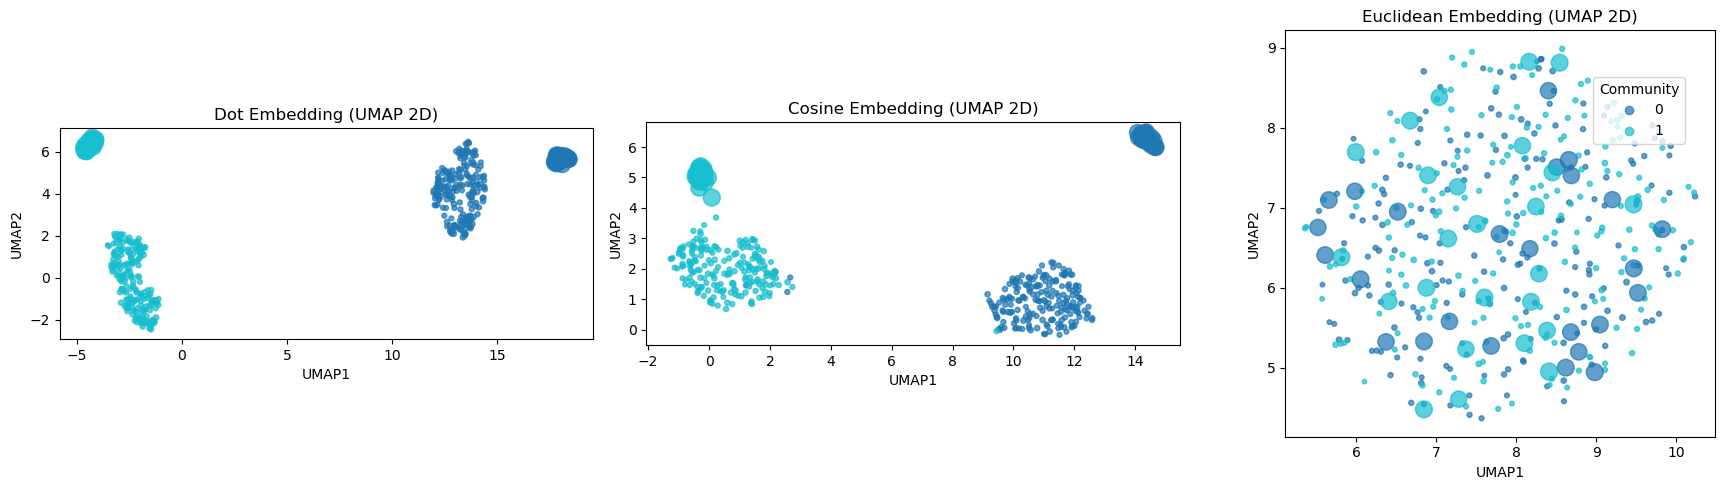

ROC-AUC on periphery communities (0 vs 1):
                dot    cosine  norm_diff  euc_on_norm
dot        0.965751  0.998851   0.501862     0.998851
cosine     0.728960  0.950361   0.498556     0.950361
euclidean  0.497230  0.493045   0.496209     0.493045


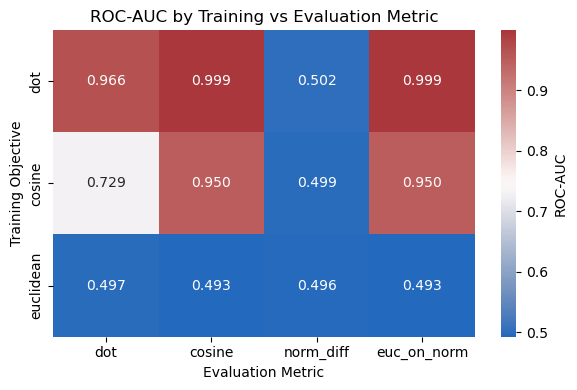

K-Means performance (ARI & Element-Centric):
           ARI_periphery  ECS_periphery  ARI_all_nodes  ECS_all_nodes
dot             1.000000       1.000000       1.000000       1.000000
cosine          0.950501       0.945907       0.955951       0.951828
euclidean      -0.001858       0.000569      -0.001248       0.000899


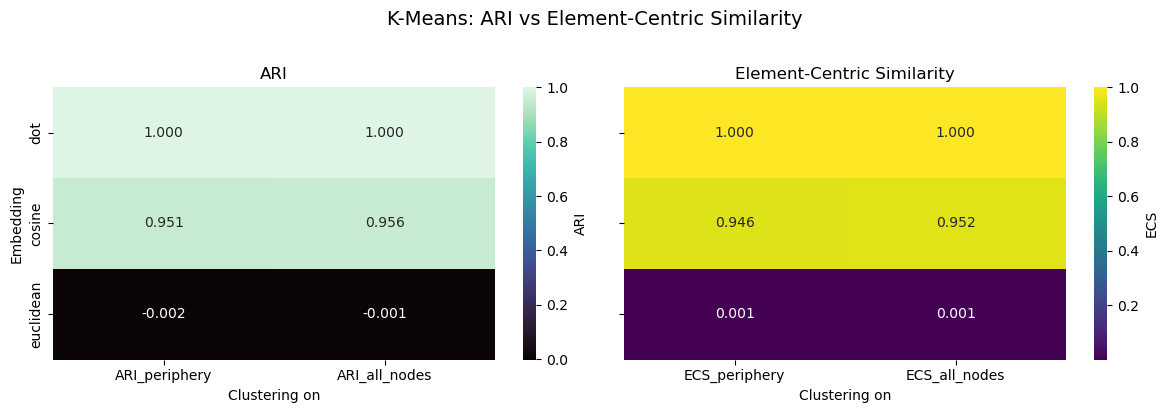

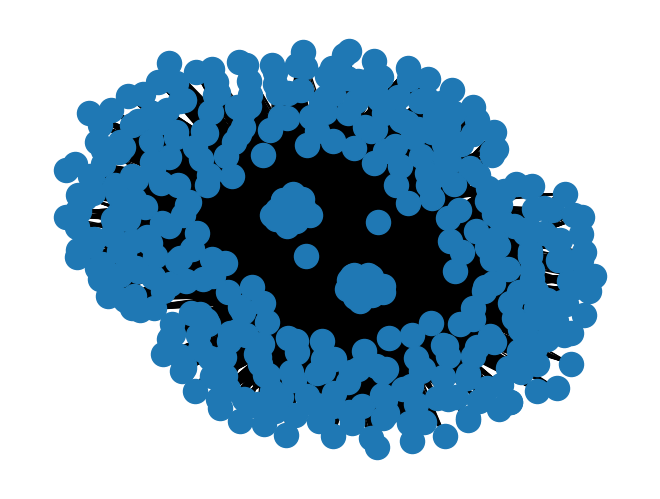

In [6]:
nx.draw(G)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:13<00:00, 108.08it/s, loss=1.38]


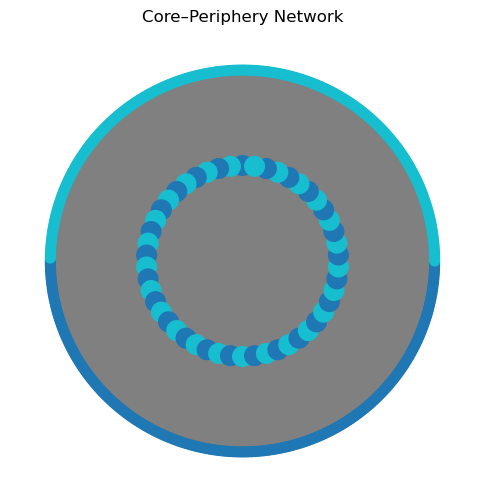

/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


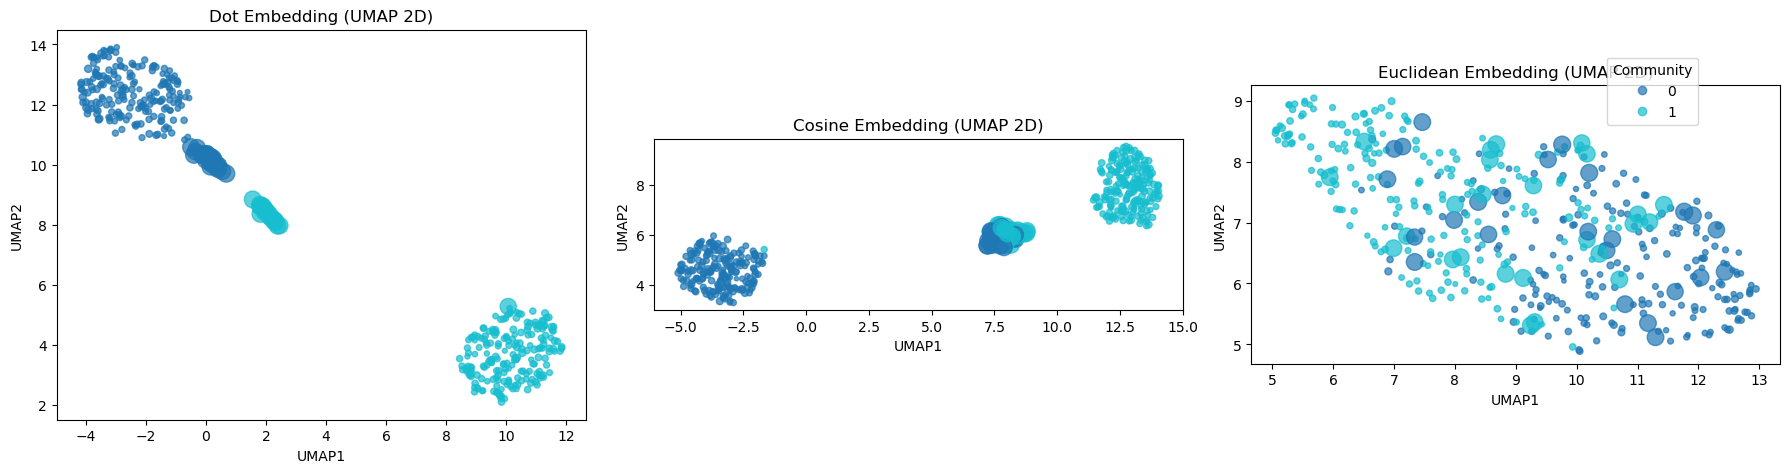

ROC-AUC on periphery communities (0 vs 1):
                dot    cosine  norm_diff  euc_on_norm
dot        0.987725  0.999851   0.506395     0.999851
cosine     0.857842  0.994634   0.496408     0.994634
euclidean  0.716301  0.713678   0.524262     0.713678


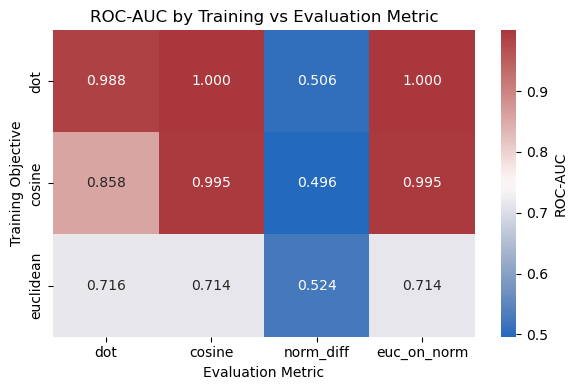

K-Means performance (ARI & Element-Centric):
           ARI_periphery  ECS_periphery  ARI_all_nodes  ECS_all_nodes
dot              1.00000       1.000000       0.991111       0.986755
cosine           1.00000       1.000000       0.895946       0.880662
euclidean        0.47479       0.446009       0.369345       0.352462


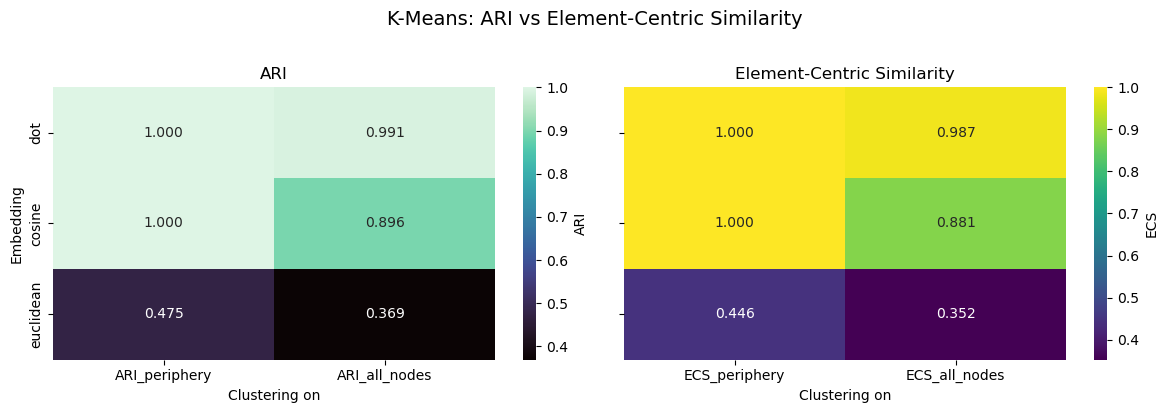

In [ ]:
# n      = 200     # no of periphery nodes in each community
# H      = 50      # number of hubs in total network ( x/2 in each community)
# p_in   = 0.20    # fairly well‐connected periphery
# p_out  = 0.005   # almost no direct cross‐links
# p_hh   = 0.90    # hubs almost fully a clique
# p_h_in = 0.90    # strong bias into home community
# p_h_out= 0.70    # still lots of cross‐community hub edges
# vector_size = 32

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:13<00:00, 104.42it/s, loss=1.38]


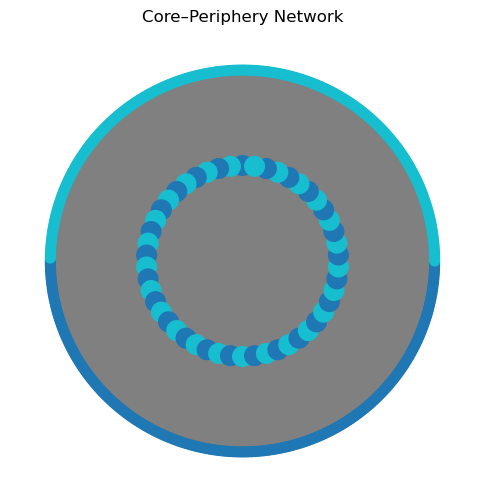

/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/

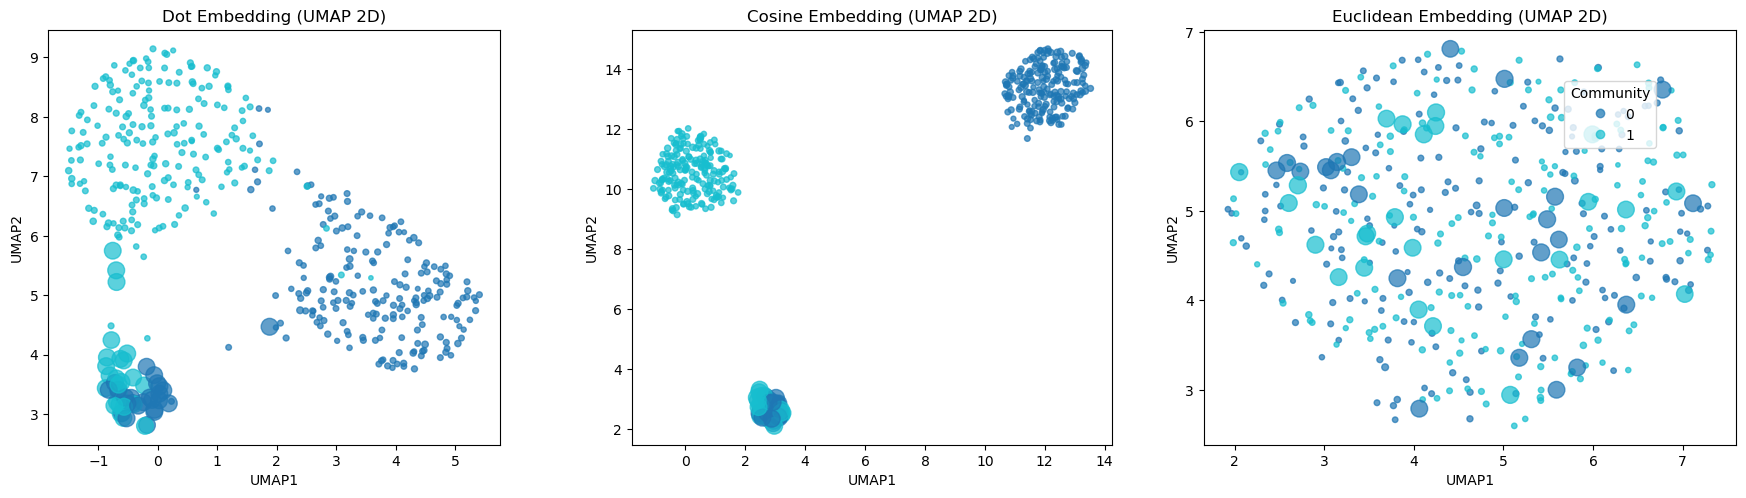

ROC-AUC on periphery communities (0 vs 1):
                dot    cosine  norm_diff  euc_on_norm
dot        0.595516  0.838612   0.496056     0.838612
cosine     0.708156  0.955468   0.497265     0.955468
euclidean  0.504784  0.510519   0.505820     0.510519


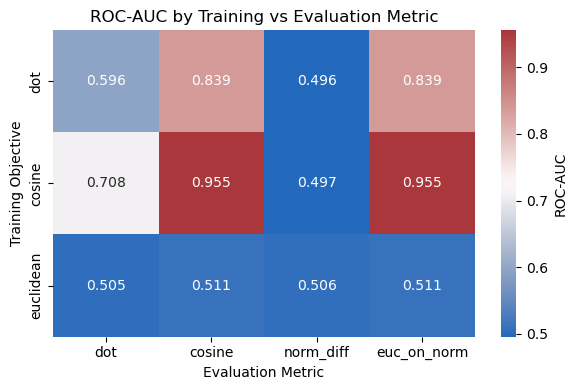

K-Means performance (ARI & Element-Centric):
           ARI_periphery  ECS_periphery  ARI_all_nodes  ECS_all_nodes
dot             0.902255       0.893609       0.750560       0.692415
cosine          1.000000       1.000000       0.829745       0.795568
euclidean      -0.001817       0.000543      -0.001910       0.000302


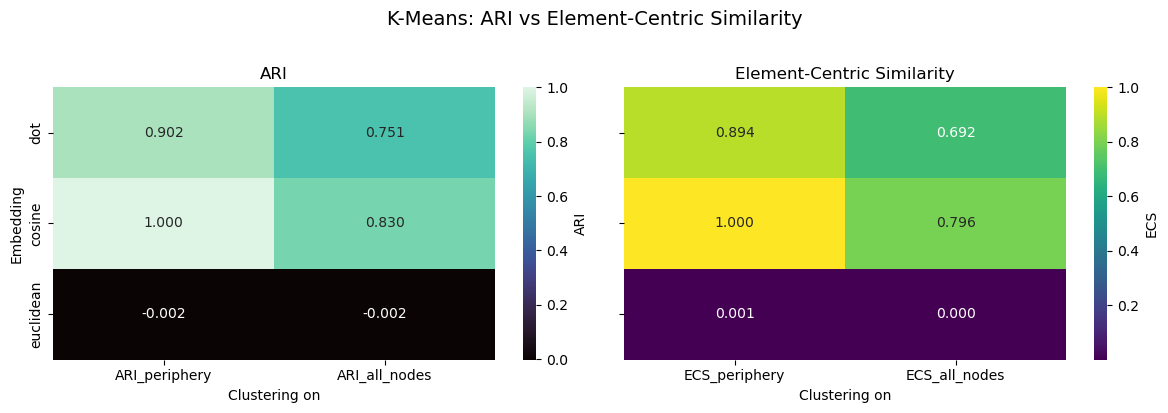

In [ ]:
# n      = 200
# H      = 50
# p_in   = 0.15
# p_out  = 0.002
# p_hh   = 0.98
# p_h_in = 0.95
# p_h_out= 0.85
# vector_size = 32


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:13<00:00, 104.52it/s, loss=1.38]


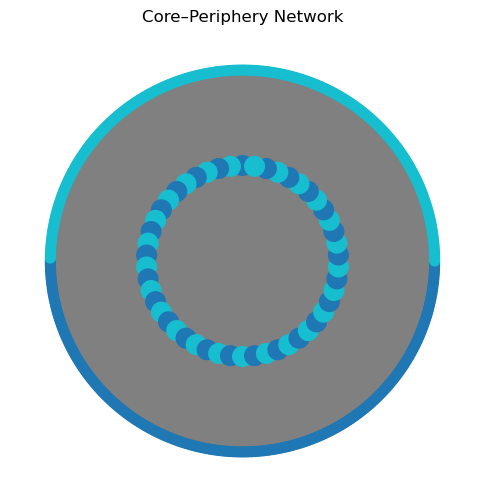

/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/

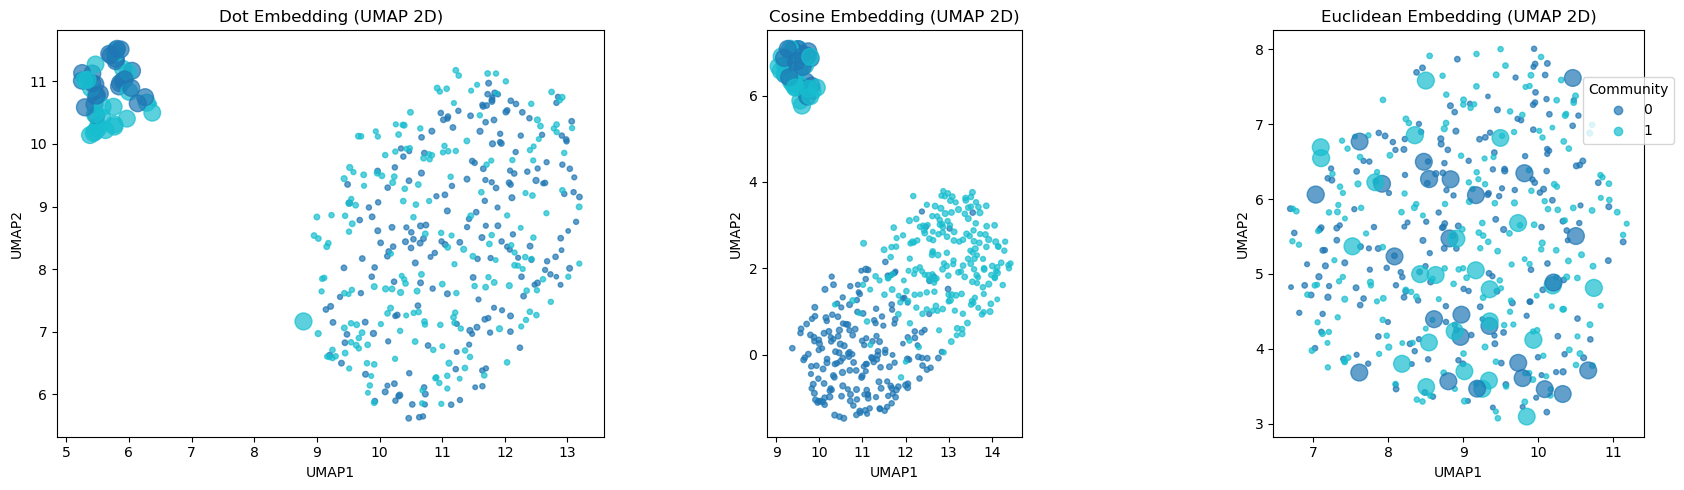

ROC-AUC on periphery communities (0 vs 1):
                dot    cosine  norm_diff  euc_on_norm
dot        0.511835  0.546060   0.501808     0.546060
cosine     0.544123  0.688661   0.503486     0.688661
euclidean  0.502747  0.503591   0.497734     0.503591


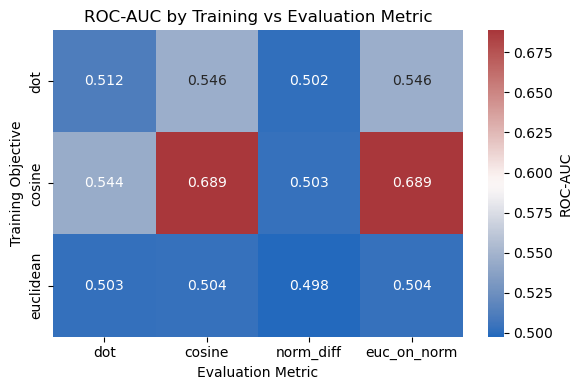

K-Means performance (ARI & Element-Centric):
           ARI_periphery  ECS_periphery  ARI_all_nodes  ECS_all_nodes
dot            -0.001598       0.000843      -0.000551       0.000355
cosine          0.696465       0.680430       0.479552       0.478589
euclidean      -0.001216       0.001065      -0.000237       0.001828


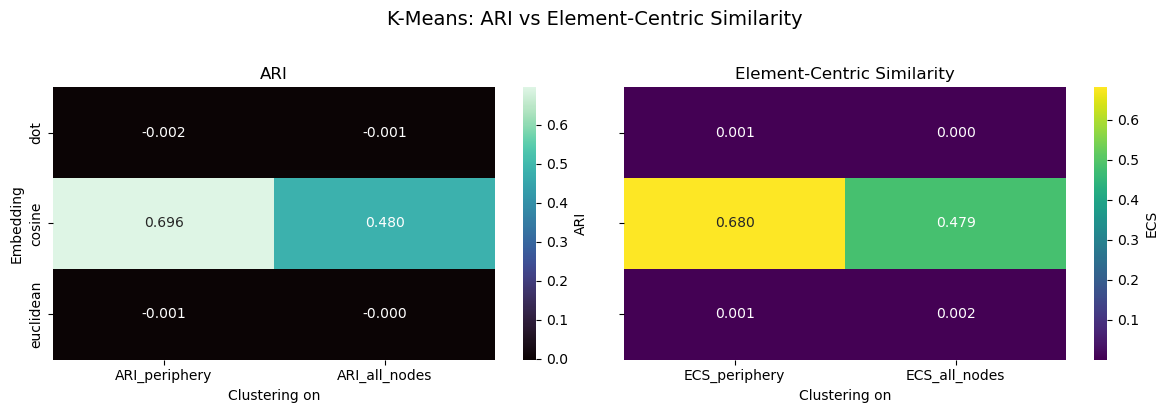

In [ ]:

# n      = 200
# H      = 50
# p_in   = 0.10
# p_out  = 0.0005
# p_hh   = 1.00
# p_h_in = 0.99
# p_h_out= 0.90
# vector_size = 32


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Assumes embeddings, n, H are defined in the environment ---

# 1) Compute raw norms and standardized norms
data = []
for metric, E in embeddings.items():
    norms = np.linalg.norm(E, axis=1)
    mean_norm = norms.mean()
    std_norm = norms.std(ddof=0)
    median_norm = np.median(norms)
    
    for idx, norm in enumerate(norms):
        node_type = 'periphery' if idx < 2 * n else 'hub'
        # standardized score (z-score)
        z = (norm - mean_norm) / std_norm
        # ratio to median
        ratio = norm / median_norm
        data.append({
            'metric': metric,
            'node_type': node_type,
            'norm': norm,
            'z_score': z,
            'median_ratio': ratio
        })

df_norms = pd.DataFrame(data)

# 2) Plot distributions on uniform scale: z-scores
plt.figure(figsize=(10, 5))
sns.violinplot(
    x='metric', y='z_score', hue='node_type',
    data=df_norms, split=True, inner='quartile',
    palette='Set2'
)
plt.title('Standardized Embedding Norms (Z-scores)\nPeriphery vs. Hubs')
plt.xlabel('Training Objective')
plt.ylabel('Norm (z-score)')
plt.legend(title='Node Type')
plt.tight_layout()
plt.show()

# 3) Plot distributions of ratios to median norm
plt.figure(figsize=(10, 5))
sns.violinplot(
    x='metric', y='median_ratio', hue='node_type',
    data=df_norms, split=True, inner='quartile',
    palette='Set2'
)
plt.title('Embedding Norms Relative to Median\nPeriphery vs. Hubs')
plt.xlabel('Training Objective')
plt.ylabel('Norm / Median Norm')
plt.legend(title='Node Type')
plt.tight_layout()
plt.show()

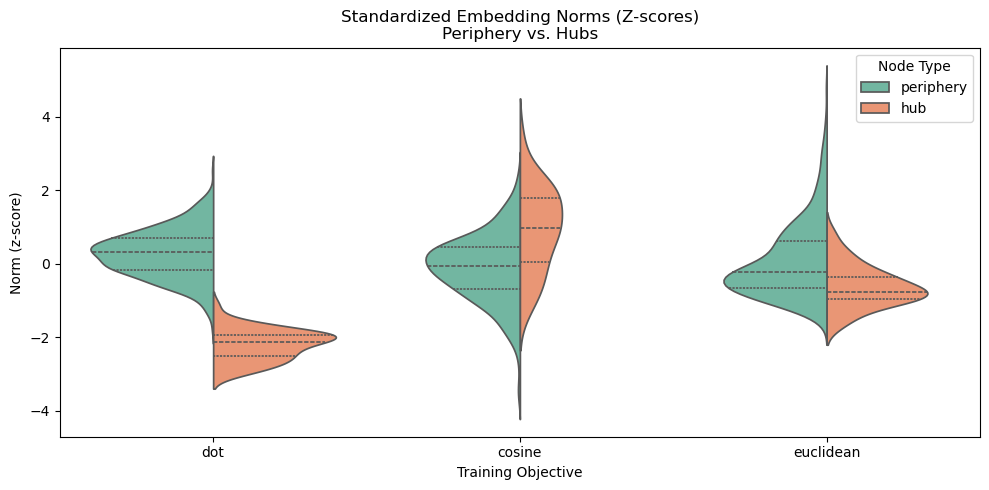

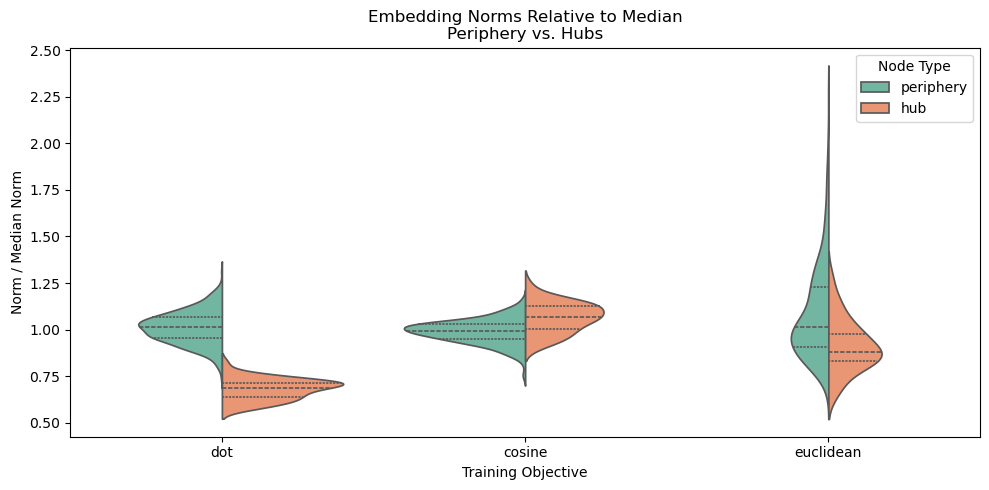

In [ ]:
#Case 1

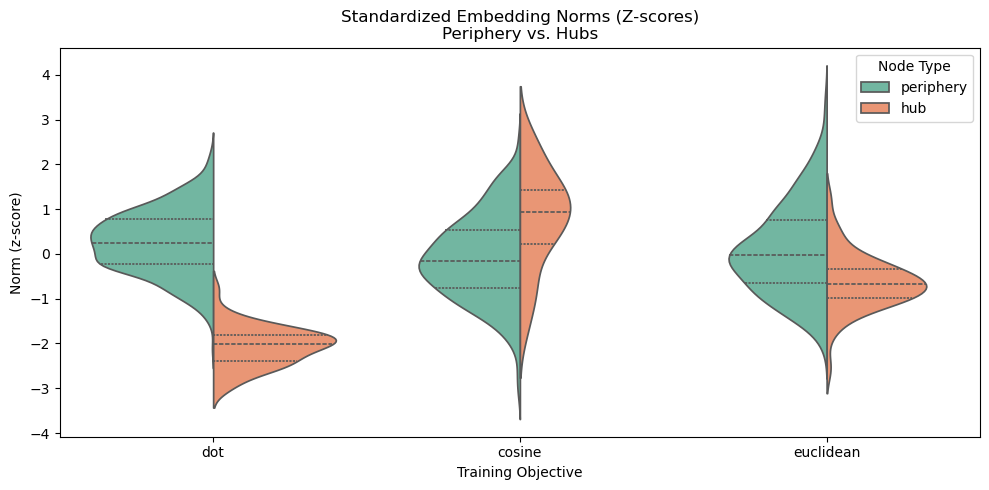

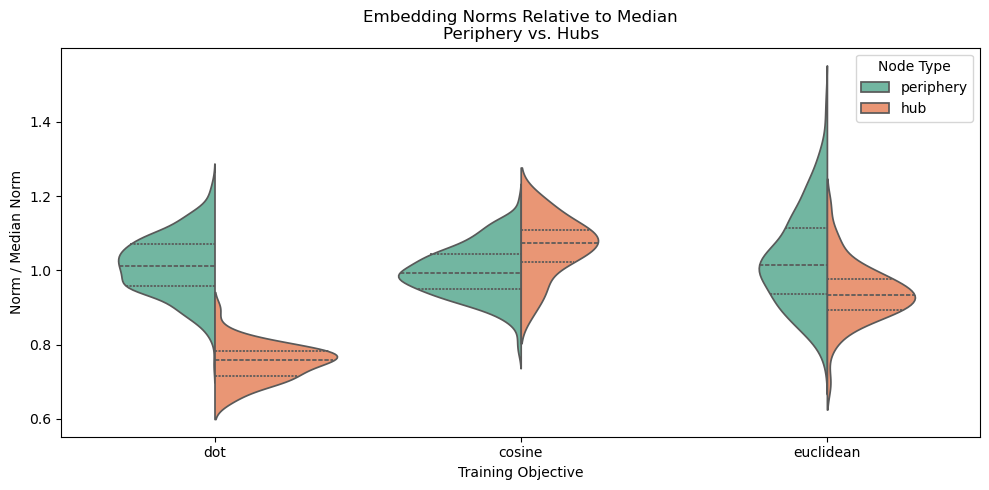

In [ ]:
# case 2

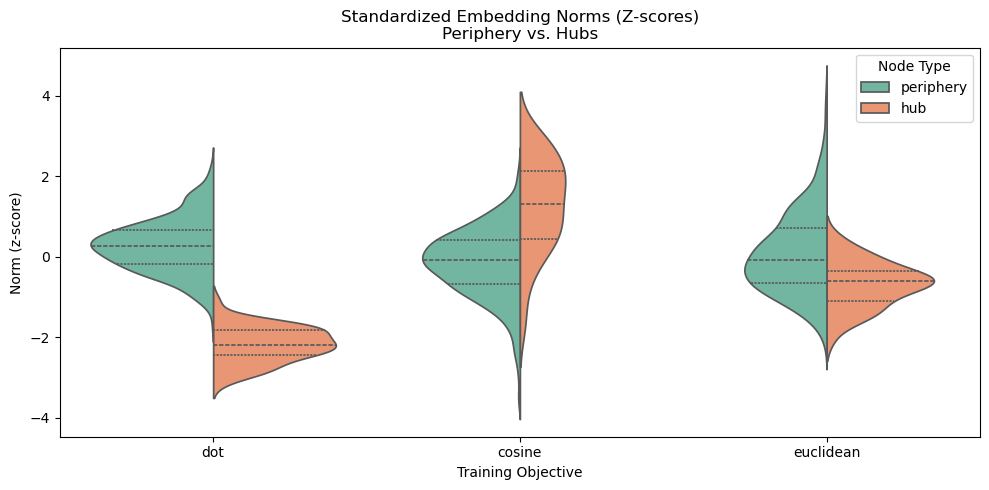

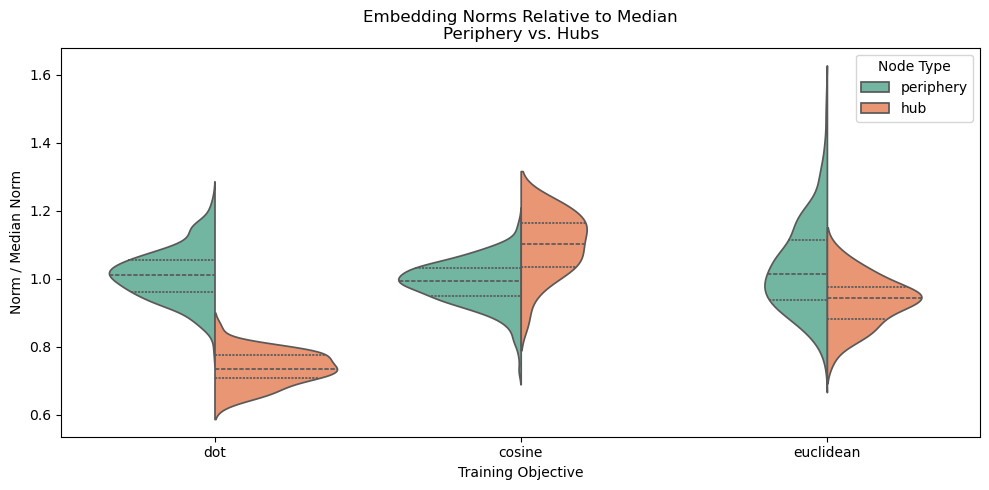

In [ ]:
#case 3